[LOG] Feature map shape: torch.Size([1, 32, 224, 224])
[LOG] Proposal 1: Crop shape: torch.Size([1, 32, 100, 100])
[LOG] Proposal 1: Resized shape: torch.Size([1, 32, 7, 7])
[LOG] Proposal 1: Vector shape: torch.Size([1, 1568])
[LOG] Proposal 1: Class logits: tensor([[-0.0208,  0.0180]], grad_fn=<AddmmBackward0>)
[LOG] Proposal 1: BBox deltas: tensor([[0.0455, 0.0508, 0.0838, 0.0557]], grad_fn=<AddmmBackward0>)
[LOG] Proposal 2: Crop shape: torch.Size([1, 32, 70, 70])
[LOG] Proposal 2: Resized shape: torch.Size([1, 32, 7, 7])
[LOG] Proposal 2: Vector shape: torch.Size([1, 1568])
[LOG] Proposal 2: Class logits: tensor([[-0.0167,  0.0030]], grad_fn=<AddmmBackward0>)
[LOG] Proposal 2: BBox deltas: tensor([[0.0329, 0.0540, 0.0866, 0.0531]], grad_fn=<AddmmBackward0>)
[LOG] Proposal 3: Crop shape: torch.Size([1, 32, 80, 80])
[LOG] Proposal 3: Resized shape: torch.Size([1, 32, 7, 7])
[LOG] Proposal 3: Vector shape: torch.Size([1, 1568])
[LOG] Proposal 3: Class logits: tensor([[-0.0227,  0.014

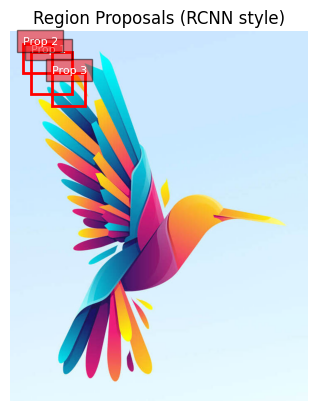

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

# ----------------------------
# Step 1: Define CNN feature extractor
# ----------------------------
class SimpleBackbone(nn.Module):
    def __init__(self):
        super(SimpleBackbone, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.features(x)

# ----------------------------
# Step 2: Define RCNN Head (Classifier + BBox Regressor)
# ----------------------------
class RCNNHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(RCNNHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.cls_layer = nn.Linear(128, num_classes)
        self.bbox_layer = nn.Linear(128, 4)  # For bounding box offsets

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        cls_logits = self.cls_layer(x)
        bbox_deltas = self.bbox_layer(x)
        return cls_logits, bbox_deltas

# ----------------------------
# Step 3: RCNN pipeline function
# ----------------------------
def rcnn_pipeline(image_tensor, proposals, backbone, rcnn_head):
    # Get feature map of whole image
    feature_map = backbone(image_tensor)
    print(f"[LOG] Feature map shape: {feature_map.shape}")  # [B, C, H, W]

    results = []

    for i, proposal in enumerate(proposals):
        x1, y1, x2, y2 = proposal
        # Crop region from feature map
        roi = feature_map[:, :, y1:y2, x1:x2]
        print(f"[LOG] Proposal {i+1}: Crop shape: {roi.shape}")

        # Resize to fixed size (e.g., 7x7)
        roi_resized = nn.functional.adaptive_avg_pool2d(roi, (7, 7))
        print(f"[LOG] Proposal {i+1}: Resized shape: {roi_resized.shape}")

        # Flatten to vector
        roi_vector = roi_resized.view(roi_resized.size(0), -1)
        print(f"[LOG] Proposal {i+1}: Vector shape: {roi_vector.shape}")

        # Pass through RCNN head
        cls_logits, bbox_deltas = rcnn_head(roi_vector)
        print(f"[LOG] Proposal {i+1}: Class logits: {cls_logits}")
        print(f"[LOG] Proposal {i+1}: BBox deltas: {bbox_deltas}")

        results.append({
            'proposal': proposal,
            'class_logits': cls_logits,
            'bbox_deltas': bbox_deltas
        })

    return results

# ----------------------------
# Step 4: Load and preprocess image
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open(r"D:\Learning\Python_DeepLearning\art.jpg").convert('RGB')
input_tensor = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

# ----------------------------
# Step 5: Define dummy region proposals
# ----------------------------
proposals = [
    (50, 50, 150, 150),
    (30, 30, 100, 100),
    (100, 100, 180, 180)
]

# ----------------------------
# Step 6: Initialize models and run pipeline
# ----------------------------
backbone = SimpleBackbone()
rcnn_head = RCNNHead(input_dim=32 * 7 * 7, num_classes=2)

# Run RCNN pipeline
results = rcnn_pipeline(input_tensor, proposals, backbone, rcnn_head)

# ----------------------------
# Step 7: Optional - visualize proposals on image
# ----------------------------
def visualize_proposals(img, proposals):
    plt.imshow(img)
    for i, (x1, y1, x2, y2) in enumerate(proposals):
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(x1, y1, f"Prop {i+1}", color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    plt.title("Region Proposals (RCNN style)")
    plt.axis('off')
    plt.show()

visualize_proposals(img, proposals)
